In [326]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import quandl
import time

In [327]:
quandl.ApiConfig.api_key = 'NFg_K_Cm9H95UyNv5Mqy'
selected = ['CNP', 'F', 'WMT', 'GE', 'TSLA']
data = quandl.get_table('WIKI/PRICES', ticker = selected,
                        qopts = { 'columns': ['date', 'ticker', 'adj_close'] },
                        date = { 'gte': '2014-1-1', 'lte': '2016-12-31' }, paginate=True)
data.head()

,date,ticker,adj_close
None,,,
0,2016-12-30,WMT,67.742045
1,2016-12-29,WMT,67.879254
2,2016-12-28,WMT,67.928257
3,2016-12-27,WMT,68.310482
4,2016-12-23,WMT,68.153672


In [328]:
# reorganise data pulled by setting date as index with
# columns of tickers and their corresponding adjusted prices
clean = data.set_index('date')
table = clean.pivot(columns='ticker')
table.head()

adj_close                                         
ticker            CNP          F         GE    TSLA        WMT
date                                                          
2014-01-02  19.116238  12.726742  24.266002  150.10  71.343743
2014-01-03  19.107861  12.784441  24.248354  149.56  71.108673
2014-01-06  19.132992  12.842140  24.054226  147.00  70.710863
2014-01-07  19.334039  12.677286  24.080698  149.36  70.927850
2014-01-08  19.132992  12.809169  24.010106  151.28  70.367299

In [329]:
# calculate daily and annual returns of the stocks
returns_daily = table.pct_change().dropna()
returns_annual = returns_daily.mean() * 250

In [330]:
# get daily and annual covariance of returns of the stock
cov_daily = returns_daily.cov()
cov_annual = cov_daily * 250

In [331]:
# empty lists to store returns, volatility and weights of imiginary portfolios
port_returns = []
port_volatility = []
sharpe_ratio = []
stock_weights = []

# set the number of combinations for imaginary portfolios
num_assets = len(selected)
num_portfolios = 50000

# populate the empty lists with each portfolios returns,risk and weights
for single_portfolio in range(num_portfolios):
    weights = np.random.random(num_assets)
    weights /= np.sum(weights)
    returns = np.dot(weights, returns_annual)
    volatility = np.sqrt(np.dot(weights.T, np.dot(cov_annual, weights)))
    sharpe = returns / volatility
    sharpe_ratio.append(sharpe)
    port_returns.append(returns)
    port_volatility.append(volatility)
    stock_weights.append(weights)

# a dictionary for Returns and Risk values of each portfolio
portfolio = {'Returns': port_returns,
             'Volatility': port_volatility,
            'Sharpe Ratio': sharpe_ratio}

# extend original dictionary to accomodate each ticker and weight in the portfolio
for counter,symbol in enumerate(selected):
    portfolio[symbol+' weight'] = [weight[counter] for weight in stock_weights]

# make a nice dataframe of the extended dictionary
df = pd.DataFrame(portfolio)

# get better labels for desired arrangement of columns
column_order = ['Returns', 'Volatility', 'Sharpe Ratio'] + [stock+' Weight' for stock in selected]

# reorder dataframe columns
#df = df[column_order]

df.head()

,Returns,Volatility,Sharpe Ratio,CNP weight,F weight,WMT weight,GE weight,TSLA weight
0,0.081169,0.167362,0.484990,0.302493,0.093639,0.065809,0.234679,0.303380
1,0.067801,0.164218,0.412874,0.227872,0.313324,0.164586,0.163986,0.130231
2,0.090842,0.168911,0.537808,0.184530,0.035696,0.244507,0.249412,0.285855
3,0.090569,0.201103,0.450361,0.004623,0.226154,0.231536,0.341212,0.196475
4,0.047283,0.152848,0.309346,0.093651,0.327257,0.373969,0.027236,0.177887


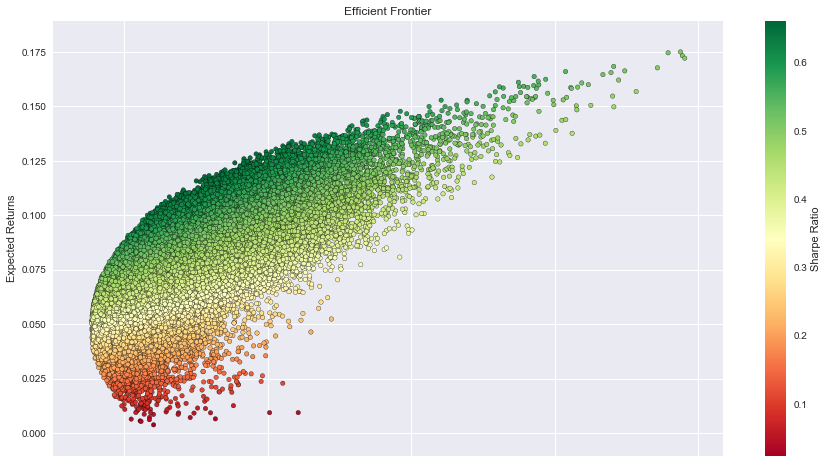

In [332]:
# plot frontier, max sharpe & min Volatility values with a scatterplot
plt.style.use('seaborn-dark')
df.plot.scatter(x='Volatility', y='Returns', c='Sharpe Ratio',
                cmap='RdYlGn', edgecolors='black', figsize=(15, 8), grid=True)
plt.xlabel('Volatility (Std. Deviation)')
plt.ylabel('Expected Returns')
plt.title('Efficient Frontier')
plt.show()

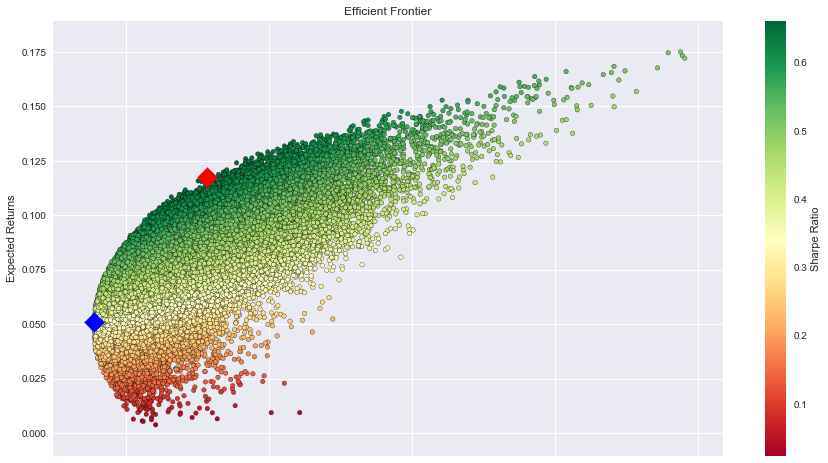

In [333]:
# find min Volatility & max sharpe values in the dataframe (df)
min_volatility = df['Volatility'].min()
max_sharpe = df['Sharpe Ratio'].max()

# use the min, max values to locate and create the two special portfolios
sharpe_portfolio = df.loc[df['Sharpe Ratio'] == max_sharpe]
min_variance_port = df.loc[df['Volatility'] == min_volatility]

# plot frontier, max sharpe & min Volatility values with a scatterplot
plt.style.use('seaborn-dark')
df.plot.scatter(x='Volatility', y='Returns', c='Sharpe Ratio',
                cmap='RdYlGn', edgecolors='black', figsize=(15, 8), grid=True)
plt.scatter(x=sharpe_portfolio['Volatility'], y=sharpe_portfolio['Returns'], c='red', marker='D', s=200)
plt.scatter(x=min_variance_port['Volatility'], y=min_variance_port['Returns'], c='blue', marker='D', s=200 )
plt.xlabel('Volatility (Std. Deviation)')
plt.ylabel('Expected Returns')
plt.title('Efficient Frontier')
plt.show()

In [334]:
# print the details of the 2 special portfolios
print(min_variance_port.T)
print(sharpe_portfolio.T)

                  4711
Returns       0.051086
Volatility    0.138600
Sharpe Ratio  0.368583
CNP weight    0.237078
F weight      0.094493
WMT weight    0.292499
GE weight     0.011922
TSLA weight   0.364008
                  9522
Returns       0.117728
Volatility    0.178065
Sharpe Ratio  0.661152
CNP weight    0.241482
F weight      0.008738
WMT weight    0.525192
GE weight     0.222138
TSLA weight   0.002451


# GA

In [342]:
# Number of the weights we are looking to optimize.
num_weights = 5

equation_inputs = np.array(returns_annual)

sol_per_pop = 20
#Defining the population size.

pop_size = (sol_per_pop,num_weights) # The population will have sol_per_pop chromosome where each chromosome has num_weights genes.

#Creating the initial population.

new_population = np.random.uniform(low=0, high=1.0, size=pop_size)
#new_population = new_population/new_population.sum(axis=1)[:,None]

In [343]:
def cal_pop_fitness(equation_inputs, pop):
    # Calculating the fitness value of each solution in the current population.
    # The fitness function calculates the sum of products between each input and its corresponding weight.
    
    returns = np.sum(pop*equation_inputs, axis=1)
    volatility = np.full(len(returns),np.nan)
    for i in range(len(pop)):
        volatility[i] = np.sqrt(np.dot(pop[i].T, np.dot(cov_annual, pop[i])))
    sharpe = returns / volatility
    fitness = sharpe
    return fitness

In [344]:
def select_mating_pool(pop, fitness, num_parents):
    
    #Selecting the best individuals in the current generation as parents for producing the offspring of the next generation.
    parents = np.empty((num_parents, pop.shape[1]))

    for parent_num in range(num_parents):
        max_fitness_idx = np.where(fitness == np.max(fitness))
        max_fitness_idx = max_fitness_idx[0][0]
        parents[parent_num, :] = pop[max_fitness_idx, :]
        fitness[max_fitness_idx] = -99999999999
    return parents

In [345]:
def crossover(parents, offspring_size):
    offspring = np.empty(offspring_size)
     # The point at which crossover takes place between two parents. Usually, it is at the center.
    crossover_point = np.uint8(offspring_size[1]/2)
 
    for k in range(offspring_size[0]):
        #Index of the first parent to mate.
        parent1_idx = k%parents.shape[0]
        #Index of the second parent to mate.
        parent2_idx = (k+1)%parents.shape[0]
        #The new offspring will have its first half of its genes taken from the first parent.
        offspring[k, 0:crossover_point] = parents[parent1_idx, 0:crossover_point]
        #The new offspring will have its second half of its genes taken from the second parent.
        offspring[k, crossover_point:] = parents[parent2_idx, crossover_point:]
    return offspring

In [346]:
def mutation(offspring_crossover):
    #Mutation changes a single gene in each offspring randomly.
    for idx in range(offspring_crossover.shape[0]):
        #The random value to be added to the gene.
        random_value = np.random.uniform(-1.0, 1.0, 1)
        offspring_crossover[idx, 4] = offspring_crossover[idx, 4] + random_value
    return offspring_crossover

In [347]:
num_generations = 200

num_parents_mating = int(sol_per_pop/2)
t = time.time()
for generation in range(num_generations):
    print(generation+1)
    for i in range(len(new_population)):
        z = (new_population[i]-min(new_population[i]))/(max(new_population[i])-min(new_population[i]))
        new_population[i] = z/z.sum()
    #new_population = new_population/new_population.sum(axis=1)[:,None]
    
    #Measuring the fitness of each chromosome in the population.
    fitness = cal_pop_fitness(equation_inputs, new_population)
    print('best fitness value:',max(fitness))
    #Selecting the best parents in the population for mating.
    parents = select_mating_pool(new_population, fitness, 
                                       num_parents_mating)
    
    #Generating next generation using crossover.
    offspring_crossover = crossover(parents, offspring_size=(pop_size[0]-parents.shape[0], num_weights))
 
    # Adding some variations to the offsrping using mutation.
    offspring_mutation = mutation(offspring_crossover)
    #Creating the new population based on the parents and offspring.
    new_population[0:parents.shape[0], :] = parents
    new_population[parents.shape[0]:, :] = offspring_mutation
    
print(time.time()-t)

1
best fitness value: 0.6457437089617859
2
best fitness value: 0.6462037774153756
3
best fitness value: 0.6462037774153756
4
best fitness value: 0.6502575026182178
5
best fitness value: 0.6502575026182178
6
best fitness value: 0.6502575026182178
7
best fitness value: 0.6502575026182178
8
best fitness value: 0.6502575026182178
9
best fitness value: 0.6502575026182178
10
best fitness value: 0.6502575026182178
11
best fitness value: 0.6502575026182178
12
best fitness value: 0.6502575026182178
13
best fitness value: 0.6556340601960574
14
best fitness value: 0.6556340601960574
15
best fitness value: 0.6556340601960574
16
best fitness value: 0.6556340601960574
17
best fitness value: 0.6556340601960574
18
best fitness value: 0.6556340601960574
19
best fitness value: 0.6556340601960574
20
best fitness value: 0.6639746367082037
21
best fitness value: 0.6639746367082037
22
best fitness value: 0.6639746367082037
23
best fitness value: 0.6639746367082037
24
best fitness value: 0.6639746367082037
2